In [1]:
import pandas as pd

data_df = pd.DataFrame()

for i in range(1,11):
    raw_data = pd.read_csv(f"./data/Borkowski et al. (2020)/plate_AL_{i}_raw_yield_and_std.csv")
    data_df = pd.concat([data_df, raw_data], ignore_index=True)

data_df.head()

,nad,folinic_acid,coa,nucleo_mix,spermidin,pga,aa,trna,mg_gluta,camp,K_gluta,yield,yield_std
0,0.165,0.0204,0.078,0.75,0.3,9,0.45,0.02,1.2,0.375,40,0.0000,0.0131
1,0.330,0.0680,0.260,1.50,1.0,30,1.50,0.20,0.4,0.750,80,0.0000,0.0095
2,0.330,0.0680,0.260,0.15,1.0,30,1.50,0.20,4.0,0.750,80,0.0000,0.0770
3,0.330,0.0680,0.260,0.45,1.0,30,1.50,0.20,4.0,0.750,80,0.0000,0.0940
4,0.330,0.0680,0.260,1.50,1.0,30,0.15,0.20,4.0,0.750,80,0.0147,0.0233


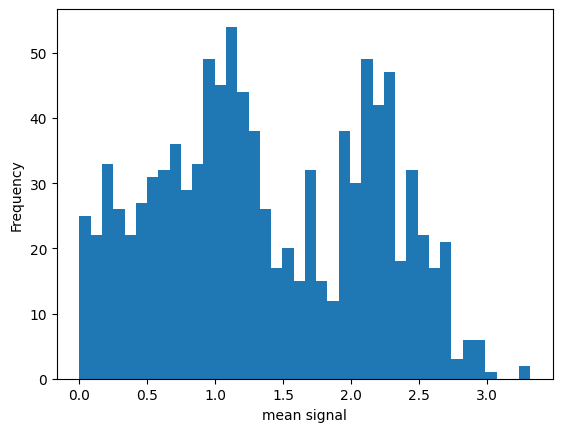

In [2]:
import matplotlib.pyplot as plt

plt.hist(data_df['yield'], bins=40)
plt.xlabel('mean signal')
plt.ylabel('Frequency')
plt.show()

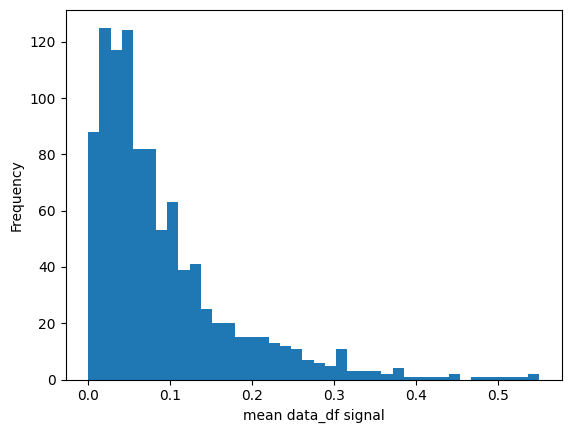

In [3]:
plt.hist(data_df['yield_std'], bins=40)
plt.xlabel('mean data_df signal')
plt.ylabel('Frequency')
plt.show()

In [4]:
X = data_df[['nad', 'folinic_acid', 'coa', 'nucleo_mix', 'spermidin', 'pga', 'aa',
       'trna', 'mg_gluta', 'camp', 'K_gluta']]
       
y = data_df[['yield']]

In [5]:
len(X), len(y)

(1017, 1017)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

## Ensemble modelling

In [7]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np

n_iter = 100 # number of random architectures to generate
ensemble_len = 10 # number of RFs in the ensemble

model = RandomForestRegressor(random_state=1)

# create a grid of hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

grid = RandomizedSearchCV(
    estimator=model, 
    param_distributions=param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    n_iter=n_iter)

# fit grid
grid.fit(X_train, y_train.values.ravel())
results = pd.DataFrame(grid.cv_results_).sort_values('mean_test_score', ascending=False)
results = results.drop_duplicates(subset=['mean_test_score'])

# build an ensemble of regressors
regressors_list = [RandomForestRegressor(**param) for param in results.params.iloc[0:ensemble_len,]]

/Users/srutidammalapati/gaussian-process-regression/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [8]:
# take top 10 regressors
regressors_list = regressors_list[:10]
len(regressors_list)

10

In [9]:
from sklearn.model_selection import cross_val_score

r2, mae = [], []
for reg in regressors_list:
    cv_mae = cross_val_score(reg, X_train, y_train.values.ravel(), cv=5, scoring='neg_mean_absolute_error')
    cv_r2 = cross_val_score(reg, X_train, y_train.values.ravel(), cv=5, scoring='r2')
    mae.append(-cv_mae.mean())
    r2.append(cv_r2.mean()) 

In [10]:
import numpy as np

np.mean(r2), np.mean(mae)

(0.9276526660423332, 0.15487312683935434)

## Plot cross validation results

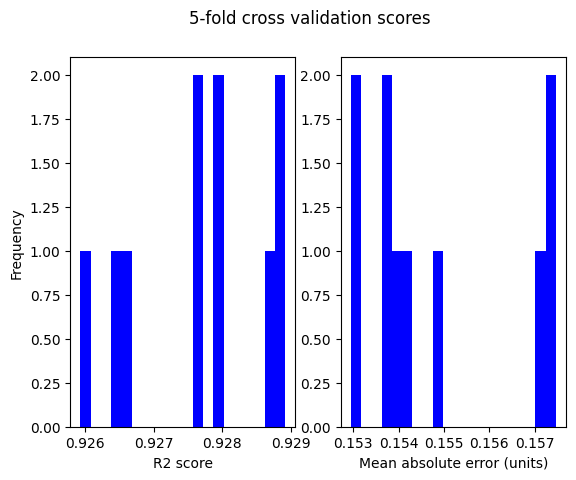

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2)
fig.suptitle('5-fold cross validation scores')
axs[0].hist(r2, bins=20, color='blue')
axs[1].hist(mae, bins=20, color='blue')

x_labels = ['R2 score', 'Mean absolute error (units)']
for i,ax in enumerate(axs.flat):
    ax.set(xlabel=x_labels[i])
    if not i:
        ax.set_ylabel('Frequency')
        
plt.show()

## Plot results on held-out test set

In [12]:
from sklearn.metrics import r2_score, mean_absolute_error
from scipy import stats

test_mae, test_r2, test_rho = [], [], []
y_pred = []
for reg in regressors_list:
    reg = reg.fit(X_train, y_train.values.ravel())
    test_r2.append(r2_score(y_test, reg.predict(X_test)))
    test_mae.append(mean_absolute_error(y_test, reg.predict(X_test))) 
    y_pred.append(reg.predict(X_test))
    test_rho.append(stats.spearmanr(reg.predict(X_test), y_test).correlation)

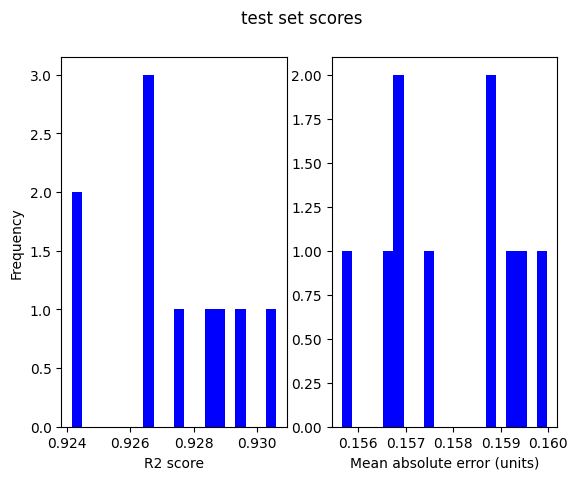

In [13]:
fig, axs = plt.subplots(1,2)
fig.suptitle('test set scores')
axs[0].hist(test_r2, bins=20, color='blue')
axs[1].hist(test_mae, bins=20, color='blue')

x_labels = ['R2 score', 'Mean absolute error (units)']
for i,ax in enumerate(axs.flat):
    ax.set(xlabel=x_labels[i])
    if not i:
        ax.set_ylabel('Frequency')
        
plt.show()

In [14]:
import numpy as np

np.mean(test_mae), np.mean(test_r2), np.mean(test_rho)

(0.15797822810754725, 0.9273375268251776, 0.9671076202313802)

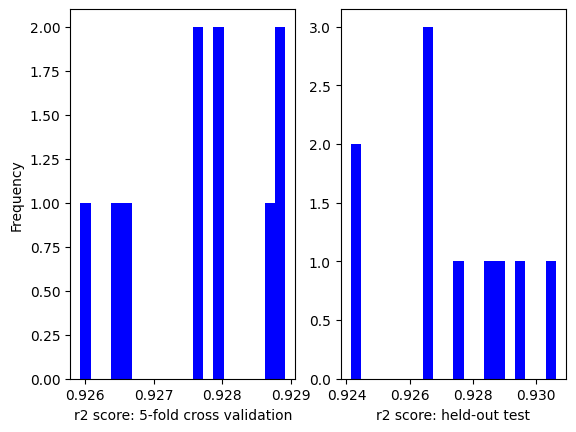

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,2)
r2 = [round(r, 5) for r in r2]
test_r2 = [round(r, 5) for r in test_r2]
axs[0].hist(r2, bins=20, color='blue')
axs[1].hist(test_r2, bins=20, color='blue')

x_labels = ['r2 score: 5-fold cross validation', 'r2 score: held-out test']

for i,ax in enumerate(axs.flat):
    ax.set(xlabel=x_labels[i])
    if not i:
        ax.set_ylabel('Frequency')
        
plt.show()

In [16]:
from sklearn.metrics import r2_score, mean_absolute_error

y_pred_train = []
for reg in regressors_list:
    reg = reg.fit(X_train, y_train.values.ravel())
    y_pred_train.append(reg.predict(X_train))

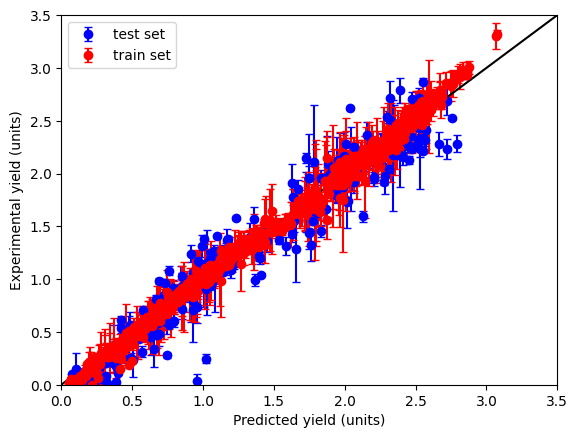

In [17]:
import numpy as np
plt.errorbar(np.mean(y_pred,axis=0), y_test.values.ravel(), yerr=data_df.iloc[y_test.index]['yield_std'], fmt='o', color='blue', capsize=3, label='test set')
plt.errorbar(np.mean(y_pred_train,axis=0), y_train.values.ravel(), yerr=data_df.iloc[y_train.index]['yield_std'], fmt='o', color='red', capsize=3, label='train set')

plt.xlabel('Predicted yield (units)')
plt.ylabel('Experimental yield (units)')
plt.ylim(0,3.5)
plt.xlim(0,3.5)
plt.axline((0, 0), slope=1, color='black')
plt.legend()
plt.show()

### Generate recommendations for testing

### Generate input combinations

In [18]:
import numpy as np
from nextorch import plotting, bo, doe, io, utils
from nextorch.parameter import Parameter, ParameterSpace
from copy import deepcopy

class RandomSampler():
    
    def __init__(self, reagent_names, concentration_ranges, y_name, initial_concentrations):
        
        self.x_name_list = reagent_names
        self.x_range_list = concentration_ranges
        self.y_name = y_name
        self.initial_concentrations = initial_concentrations

    def generate_input_combinations(self, n_init):
        parameters = [Parameter(x_type = 'continuous', x_range=x_range) for x_range in self.x_range_list]
        parameter_space = ParameterSpace(parameters)
        x_ranges = parameter_space.X_ranges

        n_dim = len(self.x_name_list) # the dimension of inputs
        n_objective = 1 # the dimension of outputs
        
        x_init_original = doe.latin_hypercube(n_dim=n_dim, n_points=n_init)
        x_init = utils.unit_to_encode_ParameterSpace(x_init_original, parameter_space)
        x_init_real = utils.inverse_unitscale_X(x_init, x_ranges)
        
        # convert to df
        df = io.np_to_dataframe(x_init_real, self.x_name_list, n = len(x_init_real))
        
        # remove samples that exceed total volume threshold
        df = self.filter_samples_above_threshold(df)
                
        return df
    
    def filter_samples_above_threshold(self, df):
        df = df.assign(total_reaction_volume = lambda x: self.calculate_total_reaction_volume(x))
        df = df[df['total_reaction_volume']<=0.4]
        return df.iloc[:,:-1]
 
    
    def calculate_total_reaction_volume(self, concentrations):
        total_volume = 0
        for reagent, final_concentration in concentrations.items():
             total_volume += final_concentration/self.initial_concentrations[reagent]*1.0
        return total_volume

In [19]:
reagent_names = ['nad', 'folinic_acid', 'coa', 'nucleo_mix', 'spermidin', 'pga', 'aa',
       'trna', 'mg_gluta', 'camp', 'K_gluta']

concentration_ranges = [
    data_df['nad'].min(), data_df['nad'].max()], \
    [data_df['folinic_acid'].min(), data_df['folinic_acid'].max()], \
    [data_df['coa'].min(), data_df['coa'].max()], \
    [data_df['nucleo_mix'].min(), data_df['nucleo_mix'].max()], \
    [data_df['spermidin'].min(), data_df['spermidin'].max()], \
    [data_df['pga'].min(), data_df['pga'].max()], \
    [data_df['aa'].min(), data_df['aa'].max()], \
    [data_df['trna'].min(), data_df['trna'].max()], \
    [data_df['mg_gluta'].min(), data_df['mg_gluta'].max()], \
    [data_df['camp'].min(), data_df['camp'].max()], \
    [data_df['K_gluta'].min(), data_df['K_gluta'].max()
                        ]

y_name= 'yield'

init_conc_list = [50, 50, 42.4, 50, 40.4, 50, 44.85, 50, 100, 50, 2500, 1000]

initial_concentrations = dict(zip(reagent_names, init_conc_list))
initial_concentrations

{'nad': 50,
 'folinic_acid': 50,
 'coa': 42.4,
 'nucleo_mix': 50,
 'spermidin': 40.4,
 'pga': 50,
 'aa': 44.85,
 'trna': 50,
 'mg_gluta': 100,
 'camp': 50,
 'K_gluta': 2500}

In [20]:
concentration_ranges

([0.033, 0.33],
 [0.0068, 0.068],
 [0.026, 0.26],
 [0.15, 1.5],
 [0.1, 1.0],
 [3, 30],
 [0.15, 1.5],
 [0.02, 0.2],
 [0.4, 4.0],
 [0.075, 0.75],
 [8, 80])

In [21]:
random_gen = RandomSampler(reagent_names, concentration_ranges, y_name, initial_concentrations)

In [22]:
n_rows = 50000

In [23]:
random_input = random_gen.generate_input_combinations(n_rows)

### Predict response

In [24]:
def predict_response(df, sort_by=['UCB']):
    
    results_df = df.copy()
    y_mean, y_std = [], []

    for i,reg in enumerate(regressors_list,1):
        reg = reg.fit(X_train, y_train.values.ravel())
        y_pred = reg.predict(df)    
        results_df['regressor_{}'.format(i)] = y_pred
        
    exploration = 0.0
    exploitation = 1.0
    
    ucb_df = results_df.copy()

    ucb_df['mean_vote'] = results_df.iloc[:,-len(regressors_list):].mean(axis=1)
    ucb_df['std_vote'] = results_df.iloc[:,-len(regressors_list):].std(axis=1)
    ucb_df['UCB'] = exploitation*ucb_df['mean_vote'] + exploration*ucb_df['std_vote']
        
    # sort by UCB
    if sort_by:
        ucb_df = ucb_df.sort_values(by=sort_by, ascending=False)
    
    return ucb_df

In [25]:
response_df = predict_response(random_input)
response_df.head()

,nad,folinic_acid,coa,nucleo_mix,spermidin,pga,aa,trna,mg_gluta,camp,...,regressor_4,regressor_5,regressor_6,regressor_7,regressor_8,regressor_9,regressor_10,mean_vote,std_vote,UCB
44370,0.225260,0.059601,0.037726,1.241564,0.169731,9.521229,0.675314,0.030604,3.126262,0.076812,...,2.571290,2.572756,2.568534,2.680969,2.575763,2.584369,2.574025,2.601897,0.045324,2.601897
7384,0.231049,0.025056,0.140466,1.221850,0.123502,7.955870,1.117677,0.062633,3.702726,0.144778,...,2.564983,2.567824,2.572481,2.675542,2.597698,2.588117,2.582482,2.601804,0.041269,2.601804
18882,0.095055,0.025987,0.080729,1.270956,0.102672,11.349317,0.775078,0.169672,3.658582,0.081344,...,2.573404,2.569824,2.572436,2.567132,2.555037,2.547306,2.553719,2.565643,0.010602,2.565643
35031,0.202710,0.035361,0.033570,1.254640,0.165631,8.886705,1.051698,0.039042,3.024170,0.121538,...,2.530306,2.535110,2.529469,2.601712,2.551397,2.556095,2.529339,2.557022,0.030421,2.557022
31002,0.323510,0.010198,0.082539,1.126525,0.105805,9.134971,1.020176,0.059432,3.141224,0.083063,...,2.533113,2.528137,2.520438,2.570792,2.522944,2.537134,2.532474,2.543453,0.024823,2.543453


In [26]:
response_df.head(10)

,nad,folinic_acid,coa,nucleo_mix,spermidin,pga,aa,trna,mg_gluta,camp,...,regressor_4,regressor_5,regressor_6,regressor_7,regressor_8,regressor_9,regressor_10,mean_vote,std_vote,UCB
44370,0.225260,0.059601,0.037726,1.241564,0.169731,9.521229,0.675314,0.030604,3.126262,0.076812,...,2.571290,2.572756,2.568534,2.680969,2.575763,2.584369,2.574025,2.601897,0.045324,2.601897
7384,0.231049,0.025056,0.140466,1.221850,0.123502,7.955870,1.117677,0.062633,3.702726,0.144778,...,2.564983,2.567824,2.572481,2.675542,2.597698,2.588117,2.582482,2.601804,0.041269,2.601804
18882,0.095055,0.025987,0.080729,1.270956,0.102672,11.349317,0.775078,0.169672,3.658582,0.081344,...,2.573404,2.569824,2.572436,2.567132,2.555037,2.547306,2.553719,2.565643,0.010602,2.565643
35031,0.202710,0.035361,0.033570,1.254640,0.165631,8.886705,1.051698,0.039042,3.024170,0.121538,...,2.530306,2.535110,2.529469,2.601712,2.551397,2.556095,2.529339,2.557022,0.030421,2.557022
31002,0.323510,0.010198,0.082539,1.126525,0.105805,9.134971,1.020176,0.059432,3.141224,0.083063,...,2.533113,2.528137,2.520438,2.570792,2.522944,2.537134,2.532474,2.543453,0.024823,2.543453
37096,0.116873,0.052915,0.027350,1.154873,0.152235,8.153924,0.667129,0.131999,3.012670,0.216898,...,2.436712,2.439684,2.437724,2.453540,2.427097,2.428418,2.420355,2.438139,0.010567,2.438139
5,0.218811,0.060303,0.084558,1.254204,0.113629,8.330672,1.014034,0.177708,3.043234,0.185172,...,2.416476,2.422027,2.420766,2.397571,2.407589,2.419831,2.423208,2.417863,0.009159,2.417863
40152,0.328678,0.044636,0.175834,1.165930,0.120970,7.196385,1.178969,0.099976,3.164879,0.157106,...,2.353717,2.356843,2.353806,2.485600,2.401614,2.397806,2.405989,2.407487,0.058001,2.407487
37958,0.081249,0.067967,0.164110,1.197274,0.120575,11.647653,1.260869,0.103486,3.191237,0.082915,...,2.390736,2.384330,2.399792,2.368335,2.367123,2.369659,2.377740,2.376832,0.014487,2.376832
37916,0.037952,0.026822,0.141253,1.298387,0.115024,7.082795,0.615207,0.109164,3.858076,0.389349,...,2.352774,2.352655,2.355802,2.401875,2.346474,2.344702,2.341549,2.363803,0.024918,2.363803


## Feature importance

In [27]:
features = ['nad', 'folinic_acid', 'coa', 'nucleo_mix', 'spermidin', 'pga', 'aa',
       'trna', 'mg_gluta', 'camp', 'K_gluta']

In [32]:
# use representative regressor
reg = regressors_list[0].fit(X_train, y_train.values.ravel())

In [33]:
r = permutation_importance(reg, X_test, y_test,
                            n_repeats=10,
                            random_state=0, scoring='neg_mean_absolute_error')
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X.columns[i] :<18}"
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

K_gluta           0.158 +/- 0.016
spermidin         0.138 +/- 0.010
nucleo_mix        0.104 +/- 0.011
aa                0.098 +/- 0.012
pga               0.071 +/- 0.008
mg_gluta          0.050 +/- 0.007
camp              0.036 +/- 0.005
nad               0.017 +/- 0.004
coa               0.012 +/- 0.004
trna              0.011 +/- 0.003


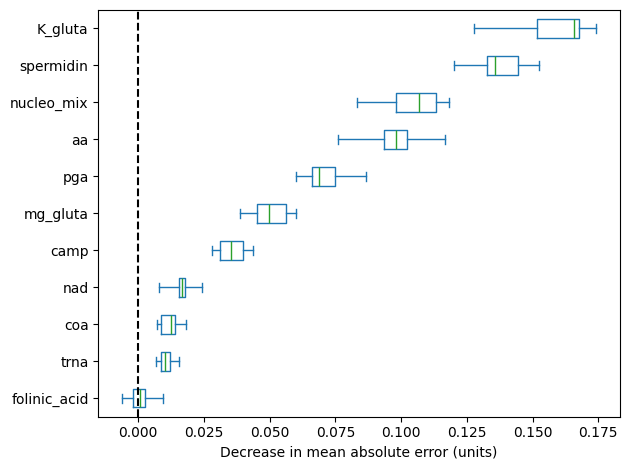

In [34]:
sorted_importances_idx = r.importances_mean.argsort()
importances = pd.DataFrame(
    r.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in mean absolute error (units)")
ax.figure.tight_layout()
plt.show()

In [35]:
import shap

explainer = shap.TreeExplainer(reg)

/Users/srutidammalapati/gaussian-process-regression/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


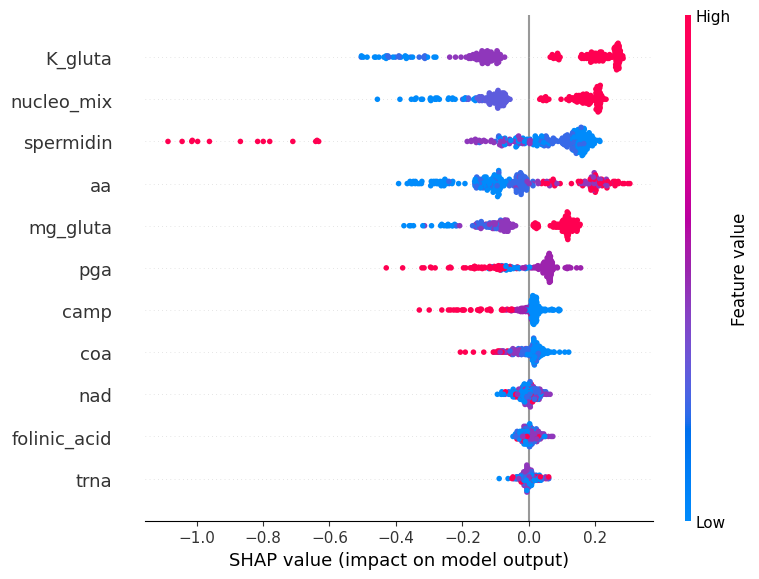

In [36]:
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=features)

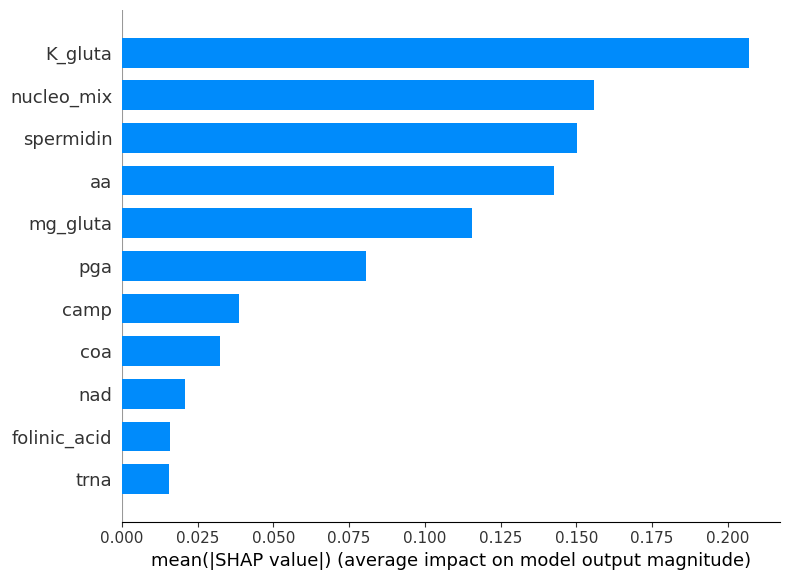

In [37]:
shap.summary_plot(shap_values, X_test, feature_names=features, plot_type="bar")

### Top Influential Features (by importance):
K_gluta, nucleo_mix, spermidin, aa, mg_gluta have the largest average impact on model predictions.

### Feature-Level Insights

**K_gluta (Potassium Glutamate)**

High values (red) → positive SHAP values → increase in protein yield
Low values (blue) → negative SHAP values
Interpretation: Increasing K_gluta boosts protein yield.

**nucleo_mix**

Higher concentrations positively impact predictions.
Suggests it's a critical nutrient or cofactor for expression.

**spermidin**

High levels drive predictions upward.
May enhance stability or translation efficiency.

**aa (Amino Acids)**

Mostly shows a positive impact.
Essential substrates for protein synthesis.

**mg_gluta (Magnesium Glutamate)**

Moderate to strong positive effect, but with saturation at high values.
Likely required for enzymatic functions and transcription.

**pga, camp, coa**

High values of these features are often associated with negative SHAP values.
Potentially inhibitory or toxic in excess.

**nad, folinic_acid, trna**

SHAP values are clustered near zero.
Minimal model impact in current conditions.

/Users/srutidammalapati/gaussian-process-regression/.venv/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 10 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


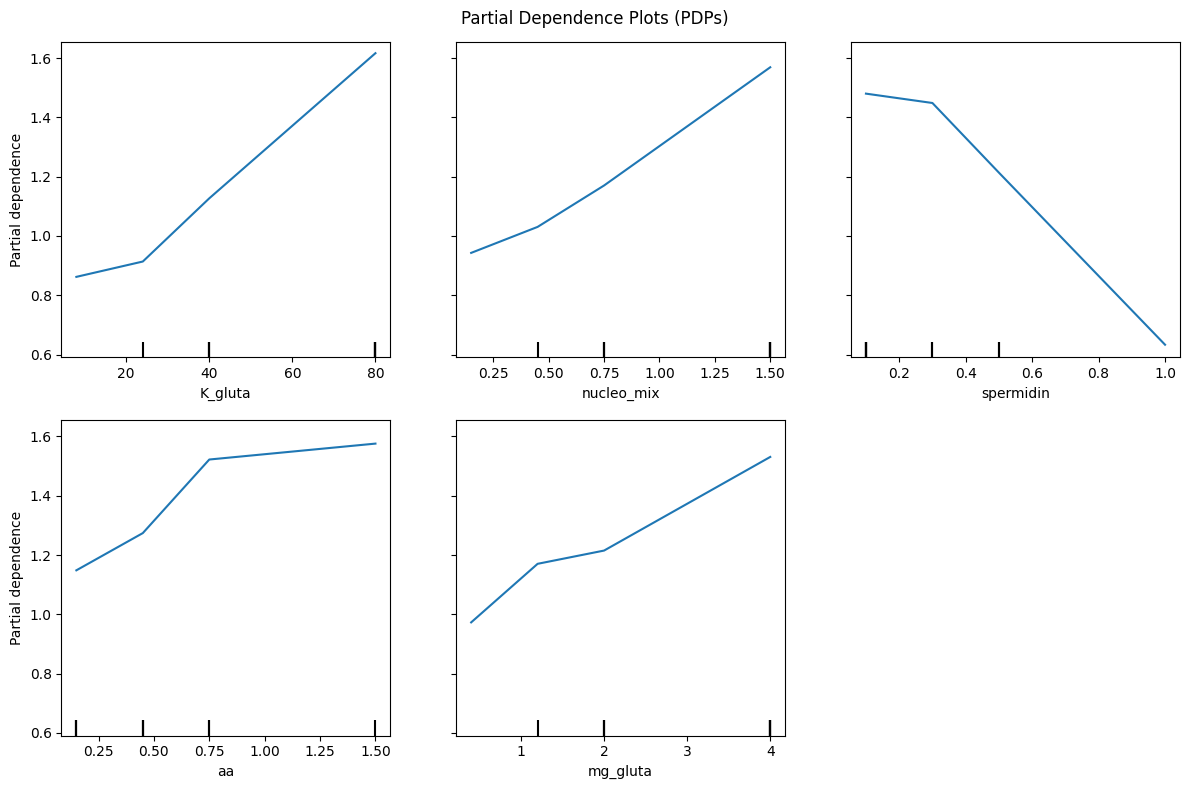

In [39]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

features_to_plot = ['K_gluta', 'nucleo_mix', 'spermidin', 'aa', 'mg_gluta']

fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    reg, X=X_test, features=features_to_plot, ax=ax
)
plt.suptitle("Partial Dependence Plots (PDPs)")
plt.tight_layout()
plt.show()


/Users/srutidammalapati/gaussian-process-regression/.venv/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 10 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


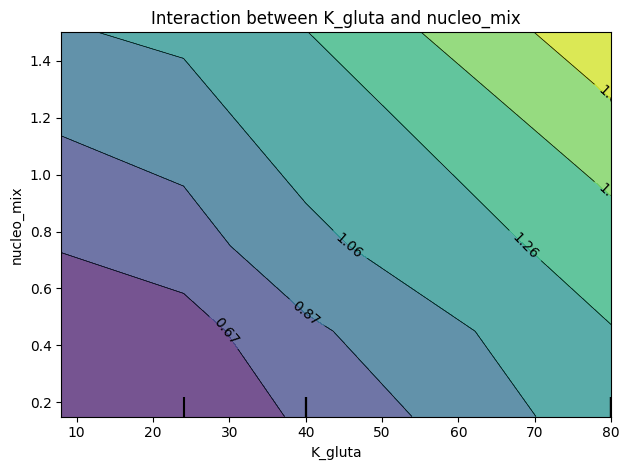

In [ ]:
PartialDependenceDisplay.from_estimator(
    reg, X=X_test, features=[('K_gluta', 'nucleo_mix')], kind='average',
    grid_resolution=30
)
plt.title("Interaction between K_gluta and nucleo_mix")
plt.tight_layout()
plt.show()
